# MODIS L2 Main table

In [1]:
# imports
from importlib import reload

import os
import numpy as np

import pandas
import xarray
import h5py

import torch
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.models import io as model_io
from ulmo.modis import io as modis_io
from ulmo.modis import analysis as analysis

In [2]:
os.environ['ENDPOINT_URL']

'https://s3.nautilus.optiputer.net'

# Load files

## Main

In [3]:
#tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.feather' # A bit slow via s3
tbl_file = os.path.join(os.getenv('SST_OOD'), 'MODIS_L2', 'Tables', 'MODIS_L2_std.feather')

In [4]:
modisl2_table = ulmo_io.load_main_table(tbl_file)

Read main table: /home/xavier/Projects/Oceanography/AI/OOD/MODIS_L2/Tables/MODIS_L2_std.feather


In [5]:
modisl2_table.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.17883,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0
1,13.043748,-102.751816,706,2003-12-12 08:30:00,432.76752,1696,0.049805,28.924648,27.789999,29.654999,29.154999,28.695000,AQUA_MODIS.20031212T083006.L2.SST.nc,107110304377724818,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,1
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.41455,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2
3,39.071575,18.569141,1028,2003-05-01 01:05:00,371.31050,898,0.049988,16.414951,15.160000,17.205000,16.725000,16.080000,AQUA_MODIS.20030501T010506.L2.SST.nc,1051129071619856914,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,3
4,17.901926,90.155480,997,2003-12-05 19:55:00,-214.75934,1520,0.035461,26.744499,24.975000,28.724998,27.824999,25.830000,AQUA_MODIS.20031205T195506.L2.SST.nc,1070107901927015548,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,4


## LL 

In [6]:
tst_file = 's3://modis-l2/Evaluations/R2010_on_2019_95clear_128x128_preproc_std_log_prob.h5'
#tst_file = os.path.join(os.getenv('SST_OOD'))'/data/Projects/Oceanography/AI/OOD/SST/MODIS_L2/Evaluations/R2010_on_2019_95clear_128x128_preproc_std_log_prob.h5'

In [7]:
with ulmo_io.open(tst_file, 'rb') as f:
    LL_hf = h5py.File(f, 'r')
#LL_hf = h5py.File(tst_file, 'r')

In [8]:
LL = LL_hf['valid'][:]

# Check

In [14]:
m2019 = modisl2_table.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'

In [15]:
np.sum(m2019), len(LL)

(751689, 751689)

In [20]:
modisl2_table[m2019][['LL', 'pp_idx', 'pp_file']][0:10]

,LL,pp_idx,pp_file
11606360,123.881836,0,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606361,419.498960,1,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606362,-137.232000,2,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606363,90.181210,3,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606364,173.312500,4,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606365,261.034670,5,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606366,178.476320,6,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606367,368.726070,7,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606368,480.007450,8,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...
11606369,482.849800,9,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...


In [17]:
LL[:10]

array([  11.026184,  297.4635  , -259.50958 ,  -56.750366,   51.403015,
        151.22833 ,   68.953   ,  216.88129 ,  338.4807  ,  382.7505  ],
      dtype=float32)

## PreProc

In [6]:
pp_file = 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
with ulmo_io.open(pp_file, 'rb') as f:
    pp_hf = h5py.File(f, 'r')

In [7]:
pp_hf.keys()

<KeysViewHDF5 ['valid', 'valid_metadata']>

In [8]:
meta = pp_hf['valid_metadata']
df = pandas.DataFrame(meta[:].astype(np.unicode_), columns=meta.attrs['columns'])

In [9]:
df.head()

,filename,row,column,latitude,longitude,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10
0,AQUA_MODIS.20190207T021000.L2.SST.nc,1232,837,-29.294142,-11.516745,0.0494384765625,25.6845760345459,22.46500015258789,26.674999237060547,26.084999084472656,25.229999542236328
1,AQUA_MODIS.20190421T000500.L2.SST.nc,1409,550,42.55745,28.580969,0.04864501953125,9.969158172607422,9.4399995803833,10.744999885559082,10.175000190734863,9.769999504089355
2,AQUA_MODIS.20190713T234501.L2.SST.nc,208,229,34.97093,28.369764,0.0,24.64632797241211,22.18000030517578,25.98499870300293,25.39499855041504,23.475000381469727
3,AQUA_MODIS.20190208T205001.L2.SST.nc,208,357,20.297197,71.70419,0.04132080078125,21.573326110839844,18.979999542236328,24.14499855041504,23.28999900817871,20.079999923706055
4,AQUA_MODIS.20190707T161001.L2.SST.nc,773,747,20.832533,145.3258,0.04986572265625,30.616931915283203,27.974998474121094,32.02000045776367,30.94999885559082,30.264999389648438


In [11]:
df.clear_fraction

0          0.0494384765625
1         0.04864501953125
2                      0.0
3         0.04132080078125
4         0.04986572265625
                ...       
751684      0.041748046875
751685       0.04931640625
751686    0.04852294921875
751687        0.0498046875
751688     0.0440673828125
Name: clear_fraction, Length: 751689, dtype: object

# LLC

In [30]:
tbl_file = 's3://llc/Tables/test_uniform_r0.5_test.feather'
llc_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://llc/Tables/test_uniform_r0.5_test.feather


,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,Tmin,Tmax,T90,T10,pp_idx,pp_type,LL
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.467546,-1.579000,-0.619,-1.351001,-1.541000,647491,0,607.481689
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-0.492408,-1.544001,3.539,3.364000,-1.540001,384768,0,241.698669
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,3.271719,1.870000,3.774,3.499000,2.540999,283882,0,391.922913
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.945127,1.368000,3.452,3.375000,2.229000,613023,0,46.060486
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.364319,1.440000,3.272,2.841000,1.891000,537161,0,243.697754


# Checking

In [13]:
main = pandas.read_feather('/data/Projects/Oceanography/AI/OOD/SST/MODIS_L2/Evaluations/R2010_results_std.feather')

In [20]:
mt = (main.row == 1232) & (main.column == 837) & (np.abs(main.latitude+29.29414)<0.001)
cutout = main.iloc[np.where(mt)[0][0]]
cutout

index                                                  0
filename            AQUA_MODIS.20190207T021000.L2.SST.nc
row                                                 1232
column                                               837
latitude                                        -29.2941
longitude                                       -11.5167
clear_fraction                                 0.0494385
mean_temperature                                 25.6846
Tmin                                              22.465
Tmax                                              26.675
T90                                               26.085
T10                                                25.23
log_likelihood                                   123.882
date                                 2019-02-07 02:10:00
UID                                   154960705916848326
Name: 11606360, dtype: object

In [19]:
LL[0]

11.026184

In [21]:
cutout.Tmax - cutout.Tmin

4.20999908447266

In [68]:
main.iloc[-1]

index                                             751688
filename            AQUA_MODIS.20190406T190500.L2.SST.nc
row                                                 1392
column                                               229
latitude                                          11.183
longitude                                        94.4305
clear_fraction                                 0.0440674
mean_temperature                                 30.4892
Tmin                                              29.215
Tmax                                               31.27
T90                                                30.81
T10                                               30.125
log_likelihood                                   284.646
date                                 2019-04-06 19:05:00
UID                                  1554101183027443051
DT                                              0.684999
Name: 12358048, dtype: object

## Scatter me

In [24]:
main['T90'] = main.T90.values.astype(float)
main['T10'] = main.T10.values.astype(float)
main['log_likelihood'] = main.log_likelihood.values.astype(float)

In [25]:
main['DT'] = main.T90 - main.T10

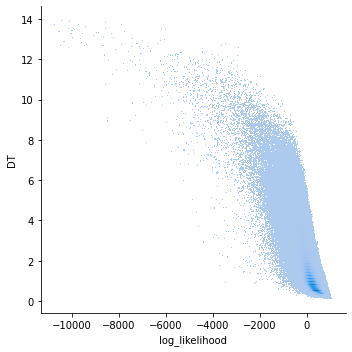

In [26]:
sns.displot(main, x='log_likelihood', y='DT')

In [27]:
df['T90'] = df.T90.values.astype(float)
df['T10'] = df.T10.values.astype(float)
df['log_likelihood'] = LL
df['DT'] = df.T90 - df.T10

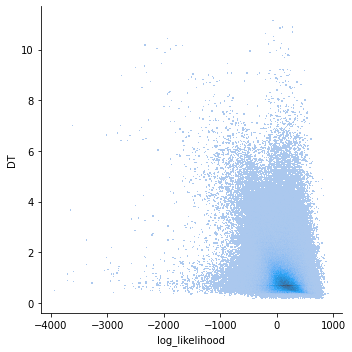

In [29]:
sns.displot(df[np.isfinite(df.log_likelihood)], x='log_likelihood', y='DT')

----

In [37]:
pp_file = '/data/Projects/Oceanography/AI/OOD/SST/MODIS_L2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
pp_hf2 = h5py.File(pp_file, 'r')

In [38]:
meta = pp_hf2['valid_metadata']
df = pandas.DataFrame(meta[:].astype(np.unicode_), columns=meta.attrs['columns'])